In [1]:
### %reload_ext autoreload

###%reset

import numpy as np

import scipy.interpolate
from scipy.stats import poisson
from scipy.stats import uniform
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp
from astropy import units as u

#For making corner plots
from getdist import plots, MCSamples

import pdb
import time

import EPDFABC as epdfabc
import subhalos as subs
import FermiBackgrounds
import DMsignal

import pickle as pk

import elfi
from elfi.methods.density_ratio_estimation import DensityRatioEstimation
#import graphviz
elfi.set_client('multiprocessing')    

#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

import abc_funcs as af

matplotlib.use('PS')

%matplotlib inline

In [2]:
channel = 'b'
run = 'run3'

#For data generation
logbins = False
if (run == 'generate'):
    load_pf = True
    load_data = False
    save_data = True
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    N_E_bins = 10
    cmax_summary = 250
    
# Comparison to exact likelihood
if (run == 'run1'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    N_E_bins = 1
    nbins_summary = 20
    cmax_summary = 240
    max_iter = 5 #5
    
# Showing that adding energy info helps
if (run == 'run2'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = False
    if (channel == 'Tau'):
        N_E_bins = 10
        nbins_summary = 15
        cmax_summary = 75
        max_iter = 5
    if (channel == 'b'):
        N_E_bins = 10
        nbins_summary = 10
        cmax_summary = 120 
        max_iter = 1

# Varying DM mass as well
if (run == 'run3'):
    load_pf = True
    load_data = True
    save_data = False
    save_posterior = True
    include_bg = True
    vary_DMmass = True
    N_E_bins = 10
    nbins_summary = 15
    cmax_summary = 75 # 70 - for tau
    max_iter = 4 #4

if (channel == 'Tau'):
    suffix = 'tau_default_NE10_MMin1_10yr'
    if (run == 'run3'):
        normalize_mean = [200., 1., 200000.]
        normalize_std = [100.0, 0.01, 10000.0]    
    else:
        normalize_mean = [0.0, 0.0, 0.0]
        normalize_std = [1.0, 1.0, 1.0] 
        
if (channel == 'b'):
    suffix = 'b_default_NE10_MMin1_10yr'
    if (run == 'run3'):
        normalize_mean = [6., 1., 50000]
        normalize_std = [1.0, 0.01, 1000.0]    
    else:
        normalize_mean = [0.0, 0.0, 0.0]
        normalize_std = [1.0, 1.0, 1.0]  

In [3]:
#parameter ranges
DM_directory = './data/dm_spectra/'
my_DM = DMsignal.DMsignal(DM_directory, channel)
default_param_dict = my_DM.get_default_model()
default_params = np.array([default_param_dict['A_DM'],\
                           default_param_dict['A_BG'],\
                           default_param_dict['mass_DM_MeV']])
print("default params = ", default_param_dict)

if (channel == 'Tau'):    
    param_min_all = np.array([0.2, 0.99, 0.1])*default_params
    param_max_all = np.array([2.5, 1.01, 1.9])*default_params                
if (channel == 'b'):
    param_min_all = np.array([0.4, 0.993, 0.1])*default_params
    param_max_all = np.array([1.7, 1.007, 1.9])*default_params  

param_min_all_norm = af.params_to_norm(param_min_all, normalize_mean, normalize_std)
param_max_all_norm = af.params_to_norm(param_max_all, normalize_mean, normalize_std)
print(param_min_all_norm)
print(param_max_all_norm)

param_names_all = np.array(['ADM', 'bgnorm', 'MDM'])
param_labels_all = np.array(['\\A_{DM}', '\\A_{\rm bg}', '\\M_{\chi}'])

if (not include_bg):
    free_indices = np.array([0])
else:
    if (not vary_DMmass):
        free_indices = np.array([0,1])
    else:
        free_indices = np.array([0,1,2])
true_params = default_params[free_indices]   
param_names = param_names_all[free_indices]
param_labels = param_labels_all[free_indices]
param_min = param_min_all[free_indices]
param_max = param_max_all[free_indices]
param_range = [param_min, param_max]
param_min_norm = param_min_all_norm[free_indices]
param_max_norm = param_max_all_norm[free_indices]
param_range_norm = [param_min_norm, param_max_norm]

print("free params = ", param_names)

default params =  {'A_DM': 5.0, 'A_BG': 1.0, 'mass_DM_MeV': 50000.0}
[ -4.   -0.7 -45. ]
[ 2.5  0.7 45. ]
free params =  ['ADM' 'bgnorm' 'MDM']


In [4]:
# Settings for subhalo analysis
physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
print(physics_settings)
print(obs_settings)

default_phipp = physics_settings['PhiPP']
N_pix = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix/12.0))

exposure = obs_settings['obs_time']*obs_settings['area']*obs_settings['fov_factor']
#Sangle = obs_settings['Omega_pixel']

print("N_side = ", N_side)

{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'M_min': 1.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.00025566346464760684, 'psi': 1.7453292519943295}
N_side =  64


In [5]:
#setup EPDFABC object

#mass should be in units of solar mass, radius should be in kpc
def mass_profile(input_params, mass, radius):
    Rs = 21 #scale radius in kpc
    beta = 1.9
    A = 1.2e4
    return A*mass**(-beta)/((radius/Rs)*(1+(radius/Rs))**2)

#mass should be in units of solar mass, radius should be in kpc
def luminosity(input_params, mass, radius):
    meanL = 77.4+0.87*np.log(mass/1e5)-0.23*np.log(radius/50)
    sig = 0.74-0.0030*np.log(mass/1e5)-0.011*np.log(radius/50)
    return meanL, sig

def spectrum(input_params, energy):
    DM_mass = input_params[2]
    return my_DM.get_dNdE(energy, channel, DM_mass)

abun_lum_spec = np.array([[mass_profile, luminosity, spectrum]])
energy_range = [1000, 100000] #this is in MeV
mass_range = [1.0e3, 1.0e10]
Rs = 21 #scale radius in kpc
radius_range = [0.35*Rs, 10*Rs] #in kpc
is_isotropic_list = [True]

my_abc = epdfabc.EPDFABC(param_range)
my_abc.setup_unbinned(abun_lum_spec, is_isotropic_list, energy_range, mass_range, radius_range, exposure, verbose = False)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


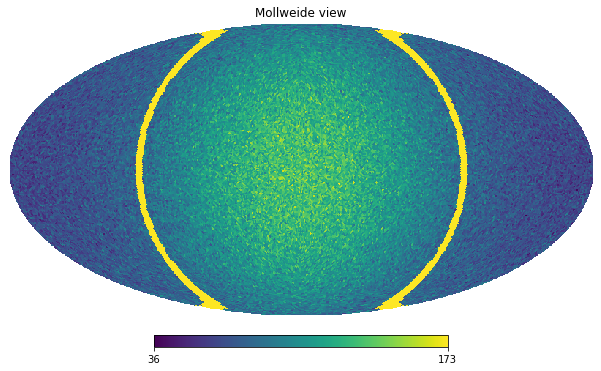

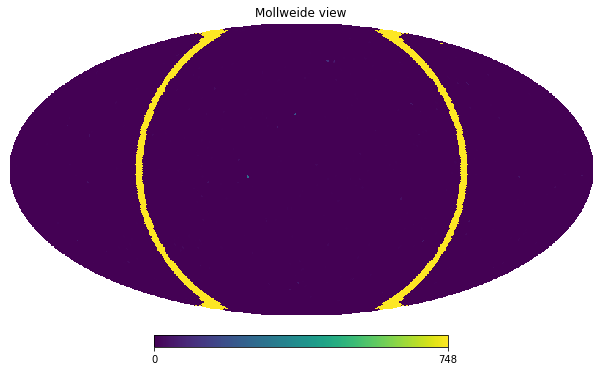

In [6]:
#generate sources and photons many times
input_params = (param_min+param_max)/2
vec = hp.ang2vec(np.pi/2, 0)
min_disc = hp.query_disc(nside=N_side, vec=vec, radius=np.radians(98))
max_disc = hp.query_disc(nside=N_side, vec=vec, radius=np.radians(102))
ring = np.setdiff1d(max_disc, min_disc)

many_s_maps = np.array([])
many_p_maps = np.array([])
for i in range(100):
    if i%5==0:
        print(i)
    source_info = my_abc.create_sources(input_params)
    photon_info = my_abc.generate_photons_from_sources(input_params, source_info)
    heatmap_s = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), 
                             bins = N_pix, range = [0.0, N_pix])
    heatmap_p = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), 
                             bins = N_pix, range = [0.0, N_pix])
    many_s_maps = np.concatenate((many_s_maps, heatmap_s[0][ring]))
    many_p_maps = np.concatenate((many_p_maps, heatmap_p[0][ring]))
    
heatmap_s[0][ring] = heatmap_s[0].max()
hp.mollview(heatmap_s[0])
heatmap_p[0][ring] = heatmap_p[0].max()
hp.mollview(heatmap_p[0])

 /home/chri3448/.conda/envs/env_healpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning:Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98.]
138.0
mu =  83.60446783625734
0.9223391812865497
0.9348095834312478
0.9999181286549708
1.0003061262190789
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

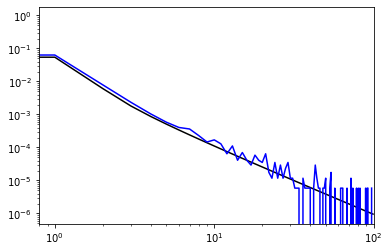

In [7]:
#many_maps = pk.load(open('./data/Test_Data/many_maps.pk','rb'))
#amputated_maps = pk.load(open('./data/Test_Data/amputated_maps.pk','rb'))
many_s_hist, many_s_bins = np.histogram(many_s_maps, bins = int(max(many_s_maps))+1, range = (0.,max(many_s_maps)+1))
amputated_p_maps = many_p_maps[np.where(many_p_maps<100)]
testdata = pk.load(open('./data/Test_Data/pf_and_pc_for_test_v02.pk','rb'))
fig, ax = pl.subplots(1,1)
ax.plot(testdata['counts'], testdata['pc'], 'k-')
many_p_hist, many_p_bins = np.histogram(many_p_maps, bins = int(max(many_p_maps))+1, range = (0.,max(many_p_maps)+1))
amputated_p_hist, amputated_p_bins = np.histogram(amputated_p_maps, bins = int(max(amputated_p_maps))+1, range = (0.,max(amputated_p_maps)+1))
ax.plot(amputated_p_bins[:-1], amputated_p_hist/np.sum(many_p_hist), 'b-')
#ax.hist(amputated_p_maps, bins = 100, density = True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.,100.])
print(amputated_p_bins)
print(max(many_s_maps))
print('mu = ', sum(many_s_hist*many_s_bins[:-1]/sum(many_s_hist)))
print(np.count_nonzero(many_p_maps == 0.)/sum(many_p_hist))
print(testdata['pc'][0])
print(sum(amputated_p_hist)/sum(many_p_hist))
print(np.sum(testdata['pc']))
print(many_s_hist/sum(many_s_hist))
print(amputated_p_hist/sum(many_p_hist))
print(testdata['pc'])